In [1]:
import os
import json
import string
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv("data/train.csv",index_col=0)

In [3]:
df['nword'] = df['sentence'].apply(lambda x: len(x.split()))

In [6]:
df['nword'].max()

181

In [22]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

/Users/lucien/.pyenv/versions/3.7.6/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [79]:
from sklearn.model_selection import train_test_split

x = df['sentence'].to_numpy()
y = df['hasDataset'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print("train: ",x_train.shape,y_train.shape)
print("val: ",x_val.shape,y_val.shape)
print("train: ",x_test.shape,y_test.shape)

train:  (191333,) (191333,)
val:  (21260,) (21260,)
train:  (23622,) (23622,)


In [81]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [82]:
model = build_classifier_model()

In [86]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.keras.metrics.AUC()

In [87]:
epochs = 5
num_train_steps = 1 * epochs
num_warmup_steps = 1

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=1,
                                          optimizer_type='adamw')

In [88]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(val_x,val_y),
    epochs=epochs,
    batch_size=512,
    )

Epoch 1/5


dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


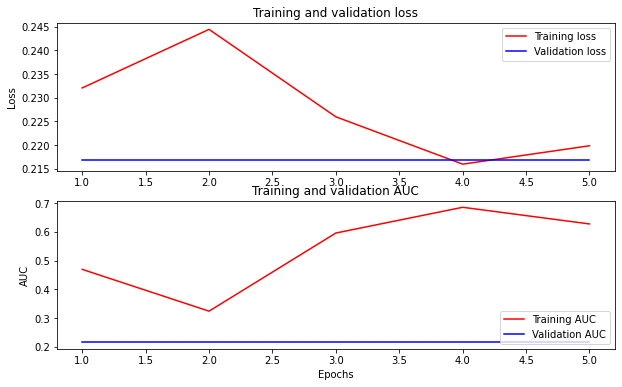

In [51]:
history_dict = history.history

acc = history_dict['auc']
val_acc = history_dict['val_auc']
loss = history_dict['loss']
val_loss = history_dict['val_auc']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training AUC')
plt.plot(epochs, val_acc, 'b', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='lower right')

In [54]:
train_y

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False])

In [53]:
val_y

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [75]:
sum(df['hasDataset'] == 1)

1346